# TODO
* Update scalars widgets

In [3]:
import pyvista as pv
import numpy as np
import xarray as xr
from JulesD3D.plotPyVista import makeBottomSurface
from JulesD3D.processNetCDF import addDepth, fixCORs, fixMeshGrid, makeVelocity, addVectorSum
from JulesD3D.utils import ncFilePicker, easyTimeFormat, folderPicker
from cmocean.cm import deep

In [2]:
pv.set_plot_theme("document") # for white background

In [6]:
# parent_folder = '/Users/julesblom/ThesisResults/'
parent_folder = '/Volumes/Seagate Expansion Drive/FinalResults'
scenario_folder = folderPicker(parent_folder)
scenario_folder

Select(description='Scenario folder:', layout=Layout(height='120px', width='100%'), options=('/Volumes/Seagate…

In [8]:
nc_filename = ncFilePicker(scenario_folder.value)  #parent_folder) 
nc_filename

Select(description='NetCDF file:', layout=Layout(height='120px', width='100%'), options=('/Volumes/Seagate Exp…

In [9]:
trim = xr.open_dataset(nc_filename.value) # Open with xarray : DataSet : A collection of DataArrays

In [10]:
timestep = -1

In [11]:
bottom_stress_attrs = {'long_name': 'Bottom stress', 'units': 'N/m2', 'grid': 'grid', 'location': 'edge1'}
bottom_stres_dims = ('time', 'M', 'N')

In [12]:
if 'velocity' not in trim:
    trim = fixMeshGrid(trim, mystery_flag=True)
    trim = addDepth(trim)
    trim = makeVelocity(trim)
    trim = addVectorSum(trim, 'TAUKSI', 'TAUETA', key="bottom_stress", attrs=bottom_stress_attrs, dims=bottom_stres_dims)
    trim.attrs['JulesD3D'] = ['fixedCORS', 'fixedMesh', 'addedHorizontalVelocity', 'addedBottomStress']
else:
    print("DataSet is preprocessed, 'velocity' is already in DataSet")

● Fixing mesh grid, assuming a uniform grid 
132 x 182 grid


In [13]:
bottom_surface_grid = makeBottomSurface(trim)

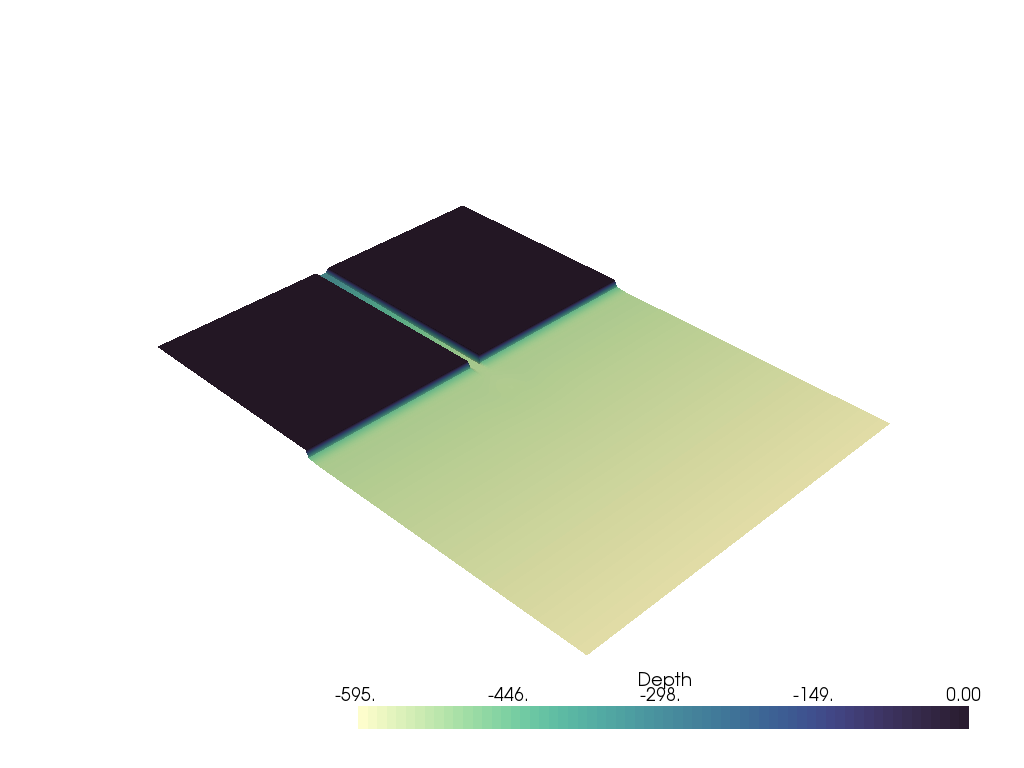

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [15]:
bottom_surface_grid.plot(cmap=deep)
# plot_title = f"{trim.bottom_stress.attrs['long_name']} ({trim.bottom_stress.attrs['units']})"

In [16]:
plot_bottom_stress = trim.bottom_stress.isel(time=timestep).values[1:-1,1:-1].T

In [17]:
plot_acc_sand_flux = np.ravel(trim.DMSEDCUM.isel(time=timestep, LSEDTOT=0).values[:-1,:-1].T)

In [56]:
plot_bottom_stress.size

23400

In [57]:
bottom_surface_grid.field_arrays['Acc Sand flux'] = plot_acc_sand_flux
bottom_surface_grid.field_arrays['Bottom stress'] = plot_bottom_stress

In [23]:
bottom_surface_grid

StructuredGrid (0x1211e5bb0)
  N Cells:	23091
  N Points:	23400
  X Bounds:	2.000e+02, 2.600e+04
  Y Bounds:	3.000e+02, 3.610e+04
  Z Bounds:	-5.952e+02, -0.000e+00
  Dimensions:	130, 180, 1
  N Arrays:	4

# Bottom Stress

In [59]:
p = pv.Plotter(notebook=False)
p.add_mesh(bottom_surface_grid, scalars='Bottom stress', cmap=deep, interpolate_before_map=False)
timestring = easyTimeFormat(trim.time.isel(time=timestep).values)
p.add_text(f"Bottom Stress at: {timestring}", position='upper_left')

# p.add_mesh(bottom_surface_grid, cmap=deep)#, scalars='Acc Sand flux', cmap='cividis', interpolate_before_map=False)
# p.add_scalar_bar(title=plot_title)
p.enable()
p.show_grid(zlabel='Depth [m]', xlabel='Width [m]', ylabel='Length [m]', ticks='outside', padding=0.3)
p.set_scale(zscale=20)
p.show()

2020-02-01T05:24:00.000000000


[(23772.679405506136, 24542.31510639866, 3297.809769926862),
 (13100.0, 18200.0, -297.5758972167969),
 (-0.6371950519306558, 0.7702421019086021, 0.026637759712621778)]

## Make a movie of bottom stress
[https://docs.pyvista.org/plotting/plotting.html#plot-time-series-data](PyVista plot Plot Time Series Data)


In [ ]:

bottom_surface_grid.field_arrays['anim_bottom_stress'] = trim.bottom_stress.isel(time=0).values[:-1,:-1].T

# bottom_surface_grid.set_active_scalars('bottom_stress')

animation_plotter = pv.BackgroundPlotter()
animation_plotter.add_mesh(grid, lighting=True, scalars='anim_bottom_stress', cmap=deep, interpolate_before_map=False)
animation_plotter.set_scale(zscale=10)
animation_plotter.show_grid()
animation_plotter.show()

def update_bottom_stress():
    for i in range(trim.time.size):
        if i % 10 == 0:
            print("time", i, "max: ", trim.bottom_stress.isel(time=i).max().values)

        # Update scalars
        new_bottom_stress = trim.bottom_stress.isel(time=i).values[:-1,:-1].T
        bottom_surface_grid.field_arrays['anim_bottom_stress'] = new_bottom_stress
        time.sleep(0.05)
        
thread = Thread(target=update_bottom_stress)
thread.start()

## Make a GIF of bottom stress

In [ ]:
# Create a plotter object and set the scalars to the Z height
plotter = pv.Plotter()
sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
plotter.add_mesh(bottom_surface_grid, scalars=trim.bottom_stress.isel(time=0).values[:-1,:-1].T,
                 cmap=deep, interpolate_before_map=False, scalar_bar_args=sargs, stitle='Bottom Stress (N/m2)')
plotter.set_scale(zscale=15)
plotter.show_grid()

In [ ]:
# https://docs.pyvista.org/examples/02-plot/gif.html#sphx-glr-examples-02-plot-gif-py
# setup camera and close

plotter.show(auto_close=False)

# Open a gif
plotter.open_gif("bottomstress1.5.gif")

pts = grid.points.copy()

for i in range(trim.time.size):
    new_bottom_stress = trim.bottom_stress.isel(time=i).values[:-1,:-1].T.ravel()
    plotter.update_scalars(new_bottom_stress)
    timetext = plotter.add_text("t = {}".format(trim.time.isel(time=i).values), position='upper_left')
    plotter.write_frame()
    plotter.remove_actor(timetext)
    
# Close movie and delete object
plotter.close()